In [1]:
import torchvision
import torch
from torch import nn, optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = torchvision.datasets.MNIST('/mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

dataset_val = torchvision.datasets.MNIST('/mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.AdaptiveAvgPool2d(1),
        )
        
        self.classifier = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 64)
        x = self.classifier(x)
        return x

simpleCNN = SimpleCNN()

In [4]:
images, labels = next(iter(loader))
print(images.shape)
pred = simpleCNN(images)
print(pred.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16, 10])


In [10]:
epochs = 10
optimizer = optim.Adam(simpleCNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
simpleCNN.cuda()
for e in range(1, epochs+1):
    total_loss = 0
    valid_loss = 0
    accuracy = 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        pred = simpleCNN(images)
        
        loss = criterion(pred, labels)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            
            pred = simpleCNN(images)
            
            loss = criterion(pred, labels)
            valid_loss += loss.item()
            
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            accuracy += acc
        
    print(f"EPOCH {e} - loss {total_loss/len(loader)} - val_loss {valid_loss/len(loader_val)} - val_acc {accuracy/len(loader_val)}")

EPOCH 1 - loss 0.29258662547866504 - val_loss 0.10494306569099426 - val_acc 0.9673999547958374
EPOCH 2 - loss 0.11214102808038394 - val_loss 0.08335135841369629 - val_acc 0.9750999808311462
EPOCH 3 - loss 0.08371246890624365 - val_loss 0.06853925411701202 - val_acc 0.9799999594688416
EPOCH 4 - loss 0.06709667773246765 - val_loss 0.05764177031517029 - val_acc 0.9813999533653259
EPOCH 5 - loss 0.056723777429262795 - val_loss 0.051372217702865604 - val_acc 0.9847999811172485
EPOCH 6 - loss 0.04985624143679937 - val_loss 0.05027123363018036 - val_acc 0.9836999773979187
EPOCH 7 - loss 0.04548177797993024 - val_loss 0.0457867616891861 - val_acc 0.986299991607666
EPOCH 8 - loss 0.04051804084777832 - val_loss 0.043480785703659056 - val_acc 0.9871999621391296
EPOCH 9 - loss 0.03799536012411118 - val_loss 0.04342444627285004 - val_acc 0.9869999885559082
EPOCH 10 - loss 0.034197585227092105 - val_loss 0.04252073523998261 - val_acc 0.9882999658584595


In [35]:
class EmbeddingCNN(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.AdaptiveAvgPool2d(1),
        )
        
        self.embedder = nn.Linear(64, embedding_size)
        
        self.codebook = nn.Embedding(10, embedding_size)
        self.codebook.weight.data.uniform_(-1./embedding_size, 1./embedding_size)	
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 64)
        x = self.embedder(x)
        return x
    
    def class2Embedding(self, x):
        return torch.index_select(self.codebook.weight, dim=0, index=x)
    
    def embedding2Class(self, x):
        codebook_sqr = torch.sum(self.codebook.weight ** 2, dim=1)
        x_sqr = torch.sum(x ** 2, dim=1, keepdim=True)

        dist  = torch.addmm(codebook_sqr + x_sqr, x, self.codebook.weight.t(), alpha=-2.0, beta=1.0)
        _, indices = dist.min(dim=1)
        return indices
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)
        
embeddingCNN = EmbeddingCNN(128)
embeddingCNN.apply(weights_init)

EmbeddingCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): AdaptiveAvgPool2d(output_size=1)
  )
  (embedder): Linear(in_features=64, out_features=128, bias=True)
  (codebook): Embedding(10, 128)
)

In [36]:
epochs = 10
optimizer = optim.Adam(embeddingCNN.parameters(), lr=0.001)
criterion = nn.MSELoss()
embeddingCNN.cuda()
for e in range(1, epochs+1):
    total_loss = 0
    valid_loss = 0
    accuracy = 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        
        embeddings = embeddingCNN.class2Embedding(labels)
        neg_embeddings = embeddingCNN.class2Embedding((labels + np.random.randint(1, 9)).fmod(10))
        pred = embeddingCNN(images)
        
        class_loss = criterion(pred, embeddings.detach()) 
        commit_loss = criterion(embeddings, pred.detach()) * 0.25
        triplet_loss = nn.functional.triplet_margin_loss(pred, embeddings, neg_embeddings)
        kld_loss = nn.functional.kl_div(pred, torch.randn_like(pred), reduction='mean')
        
        loss = class_loss + commit_loss + triplet_loss + kld_loss
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            
            embeddings = embeddingCNN.class2Embedding(labels)
            neg_embeddings = embeddingCNN.class2Embedding((labels + np.random.randint(1, 9)).fmod(10))
            pred = embeddingCNN(images)
            
            class_loss = criterion(pred, embeddings.detach()) 
            commit_loss = criterion(embeddings, pred.detach()) * 0.25
            triplet_loss = nn.functional.triplet_margin_loss(pred, embeddings, neg_embeddings)
            kld_loss = nn.functional.kl_div(pred, torch.randn_like(pred), reduction='mean')

            loss = class_loss + commit_loss + triplet_loss + kld_loss
            valid_loss += loss.item()
            
            acc = (embeddingCNN.embedding2Class(pred) == labels).float().mean()
            accuracy += acc
        
    print(f"EPOCH {e} - loss {total_loss/len(loader)} - val_loss {valid_loss/len(loader_val)} - val_acc {accuracy/len(loader_val)}")

EPOCH 1 - loss 0.09351960283393661 - val_loss -0.021668753093481066 - val_acc 0.9264999628067017
EPOCH 2 - loss -0.05942024754782518 - val_loss -0.10503836764097214 - val_acc 0.9520999789237976
EPOCH 3 - loss -0.1448974824229876 - val_loss -0.19136499843597413 - val_acc 0.9731999635696411
EPOCH 4 - loss -0.24116837822198867 - val_loss -0.29540145597457884 - val_acc 0.9646999835968018
EPOCH 5 - loss -0.350162947956721 - val_loss -0.4107233135223389 - val_acc 0.9787999987602234
EPOCH 6 - loss -0.46993940552870433 - val_loss -0.535689046382904 - val_acc 0.9836999773979187
EPOCH 7 - loss -0.5997680111885071 - val_loss -0.6620852843761444 - val_acc 0.9776999950408936
EPOCH 8 - loss -0.737322125585874 - val_loss -0.8099502658843994 - val_acc 0.9811999797821045
EPOCH 9 - loss -0.888516604423523 - val_loss -0.969759555530548 - val_acc 0.9851999878883362
EPOCH 10 - loss -1.0522149425506593 - val_loss -1.1415159490585327 - val_acc 0.9855999946594238


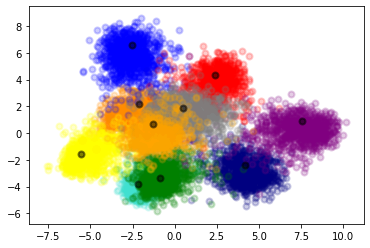

In [44]:
embeddingCNN.eval()

all_labels = []
all_embeddings = []
with torch.no_grad():
    for images, labels in loader_val:
        images, labels = images.cuda(), labels.cuda()

        pred = embeddingCNN(images)
        
        all_labels += labels.cpu().numpy().tolist()
        all_embeddings += pred.cpu().numpy().tolist()
        
all_labels = np.array(all_labels)
all_embeddings = np.array(all_embeddings)

pca = PCA(n_components=2).fit(all_embeddings)
pca_embeddings = pca.transform(all_embeddings)
pca_labels = pca.transform(embeddingCNN.codebook.weight.cpu().detach().numpy())


colors = ['navy', 'turquoise', 'darkorange', 'blue', 'green', 'red', 'purple', 'yellow', 'grey', 'orange']
lw = 2

plt.figure()

for color, i in zip(colors, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    plt.scatter(pca_embeddings[all_labels == i, 0], pca_embeddings[all_labels == i, 1], color=color, alpha=.2, lw=lw)

for label, color in zip(pca_labels, colors):
    plt.scatter(label[0], label[1], color='black', alpha=0.5, lw=lw)
    
plt.show()